In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import os
import shutil
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
import datetime
import gensim
from gensim import corpora



In [5]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/santoshbhogi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
# Load dataset
df = pd.read_csv("Kult_App.csv")  # Ensure the CSV has "Review", "Date", "Rating", and "Version" columns

In [7]:
df.sort_values('Reply')

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness
33,Adithya Murali,5,28 July 2024,Kult makes finding the right skincare and beau...,Kult E-commerce,2024-07-29,"('N/A', 'N/A')"
284,Anishka Gupta,1,28 May 2024,"Kindly ensure the payment gateway is working, ...",Kult E-commerce,2024-06-03,2 people found this review helpful
283,Samra Siddiq,2,28 May 2024,The products are no longer back. What is this?,Kult E-commerce,2024-06-03,"('N/A', 'N/A')"
282,Ananya Prabhu,4,28 May 2024,PLEASE RESTOCKKK!!,Kult E-commerce,2024-06-03,"('N/A', 'N/A')"
281,ARENSENLA JAMIR,1,30 May 2024,Fraud app. My product is missing. I have sent ...,Kult E-commerce,2024-06-03,2 people found this review helpful
...,...,...,...,...,...,...,...
29,Ritaj,1,27 August 2024,"Horrible service, they will not ship ur orders...",NaN,NaN,7 people found this review helpful
30,Aarti Sukale,1,24 August 2024,Kult aap is fraud app i didn't receive my refu...,NaN,NaN,1 person found this review helpful
31,Prakriti Singh,1,24 August 2024,"Theives. I've shopped for 25k+, and have had s...",NaN,NaN,6 people found this review helpful
32,Tasnim Tahira,1,22 August 2024,Such a horrible app . I placed my order on 5 t...,NaN,NaN,9 people found this review helpful


In [8]:
# Convert Date columns to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Handle invalid dates
df['Reply Date'] = pd.to_datetime(df['Reply Date'], errors='coerce')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Username    404 non-null    object        
 1   Rating      404 non-null    int64         
 2   Date        404 non-null    datetime64[ns]
 3   Review      404 non-null    object        
 4   Reply       370 non-null    object        
 5   Reply Date  370 non-null    datetime64[ns]
 6   Usefulness  404 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 22.2+ KB


In [10]:
# Standardize text
df['Review'] = df['Review'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

In [11]:
# Calculate response time (handles NaT and invalid dates)
df['Reply_Time_Days'] = (df['Reply Date'] - df['Date']).dt.days

# Force integer dtype 
df['Reply_Time_Days'] = df['Reply_Time_Days'].astype('Int64') 




In [12]:
# Fill missing Values
df['Reply'].fillna("No Reply", inplace=True)


/var/folders/6d/_h_2x7gj7s17l9hkm1jq2x2w0000gp/T/ipykernel_37739/60940501.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Reply'].fillna("No Reply", inplace=True)


In [13]:
import numpy as np

# Strip non-digit characters
df['Usefulness'] = df['Usefulness'].str.replace(r'[^\d]', '', regex=True)

# Replace empty strings with NaN
df['Usefulness'] = df['Usefulness'].replace('', np.nan)

# Convert to nullable integer type and fill missing with 0
df['Usefulness'] = df['Usefulness'].astype('Int64').fillna(0)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Username         404 non-null    object        
 1   Rating           404 non-null    int64         
 2   Date             404 non-null    datetime64[ns]
 3   Review           404 non-null    object        
 4   Reply            404 non-null    object        
 5   Reply Date       370 non-null    datetime64[ns]
 6   Usefulness       404 non-null    Int64         
 7   Reply_Time_Days  370 non-null    Int64         
dtypes: Int64(2), datetime64[ns](2), int64(1), object(3)
memory usage: 26.2+ KB


2. Feature Engineering

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
df['Sentiment_Score'] = df['Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['Sentiment'] = pd.cut(df['Sentiment_Score'], 
                         bins=[-1, -0.05, 0.05, 1], 
                         labels=['Negative', 'Neutral', 'Positive'])


In [16]:
import re
import pandas as pd

def detect_device_mentions(reviews_df):
    device_patterns = {
        'iPhone': r'iphone|iOS',
        'Samsung': r'samsung|galaxy',
        'Pixel': r'pixel|google phone',
        'OnePlus': r'oneplus|one plus',
        'Xiaomi': r'xiaomi|redmi|poco',
        'Android': r'\bandroid\b(?!.*(ios|iphone))',
        'iOS': r'\bios\b|apple',
        'Tablet': r'tablet|ipad|galaxy tab'
    }
    
    results = []
    for _, row in reviews_df.iterrows():
        review = str(row['Review']).lower()  # Ensure string conversion
        devices = []
        for device, pattern in device_patterns.items():
            if re.search(pattern, review, flags=re.IGNORECASE):
                devices.append(device)
        results.append({
            'Username': row['Username'],  # Using Username as identifier instead of Review_ID
            'Rating': row['Rating'],
            'Devices_Mentioned': ', '.join(devices) if devices else 'None',
            'Review_Excerpt': review[:100] + '...'  # First 100 chars of review
        })
    
    return pd.DataFrame(results)

# Usage
device_mentions = detect_device_mentions(df)
device_stats = device_mentions['Devices_Mentioned'].value_counts()
print(device_stats)

Devices_Mentioned
None                    400
Android                   1
iPhone                    1
Xiaomi, Tablet            1
iPhone, Android, iOS      1
Name: count, dtype: int64


In [17]:
df.head(10)

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral
5,Riya Blue,1,2025-01-09,so bad ive been trying to open the app for two...,No Reply,NaT,1,<NA>,-0.2875,Negative
6,HARLEEN Kaur,1,2024-12-31,cant even get an otp even tried from differen...,No Reply,NaT,1,<NA>,0.0000,Neutral
7,Harshita Aggarwal,1,2024-12-30,dead app,No Reply,NaT,1,<NA>,-0.6486,Negative
8,anshika gupta,1,2024-12-29,unable to sign up trying for last 5 days they ...,No Reply,NaT,4,<NA>,0.0000,Neutral
9,Minakshi Pandey,1,2024-12-29,it keeps bluffing i deleted and install again ...,No Reply,NaT,1,<NA>,0.0000,Neutral


3. NLP Processing

In [18]:
import os
import shutil
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. CLEAN SLATE APPROACH
nltk_data_path = r'venv/nltk_data'
if os.path.exists(nltk_data_path):
    print(f"Removing existing NLTK data at {nltk_data_path}...")
    try:
        shutil.rmtree(nltk_data_path)
    except Exception as e:
        print(f"Couldn't remove directory: {e}")

# 2. FRESH INSTALLATION
print("Performing fresh NLTK data download...")
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)  # Add this line

# 3. VERIFICATION STEPS
print("\nVerifying installation...")
try:
    # Explicitly set the data path
    nltk.data.path = [nltk_data_path]
    
    # Verify the path is set correctly
    print(f"NLTK data paths: {nltk.data.path}")
    
    # Test stopwords
    stop_words = set(stopwords.words('english'))
    print(f"✓ Stopwords loaded successfully (sample: {list(stop_words)[:5]})")
    
    # Test tokenizer
    test_tokens = word_tokenize("This is a test sentence.")
    print(f"✓ Tokenizer working (test tokens: {test_tokens})")
except Exception as e:
    print(f"Verification failed: {e}")
    raise

# Rest of your code...

Removing existing NLTK data at venv/nltk_data...
Performing fresh NLTK data download...


[nltk_data] Downloading package stopwords to venv/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to venv/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to venv/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Verifying installation...
NLTK data paths: ['venv/nltk_data']
✓ Stopwords loaded successfully (sample: ["that'll", 'why', "isn't", 'into', 'i'])
✓ Tokenizer working (test tokens: ['This', 'is', 'a', 'test', 'sentence', '.'])


In [19]:
# 1. CLEAN SLATE APPROACH - Remove any potentially corrupted downloads
nltk_data_path = r'venv/nltk_data'
if os.path.exists(nltk_data_path):
    print(f"Removing existing NLTK data at {nltk_data_path}...")
    try:
        shutil.rmtree(nltk_data_path)
    except Exception as e:
        print(f"Couldn't remove directory: {e}")

# 2. FRESH INSTALLATION
print("Performing fresh NLTK data download...")
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)

# 3. VERIFICATION STEPS
print("\nVerifying installation...")
try:
    # Explicitly set the data path
    nltk.data.path = [nltk_data_path]
    
    # Test stopwords
    stop_words = set(stopwords.words('english'))
    print(f"✓ Stopwords loaded successfully (sample: {list(stop_words)[:5]})")
    
    # Test tokenizer
    test_tokens = word_tokenize("This is a test sentence.")
    print(f"✓ Tokenizer working (test tokens: {test_tokens})")
except Exception as e:
    print(f"Verification failed: {e}")
    raise

# 4. PROCESSING FUNCTION WITH ERROR HANDLING
def preprocess(text):
    try:
        words = word_tokenize(str(text))
        return [word for word in words if word.isalpha() and word not in stop_words]
    except Exception as e:
        print(f"Error processing text: {str(text)[:50]}... Error: {e}")
        return []

# 5. PROCESS DATA IN CHUNKS
print("\nProcessing reviews...")
chunk_size = 100
for i in range(0, len(df), chunk_size):
    chunk = df.iloc[i:i+chunk_size]
    df.loc[chunk.index, 'Tokens'] = chunk['Review'].apply(preprocess)
    print(f"Processed {min(i+chunk_size, len(df))}/{len(df)} reviews")

print("✅ Text preprocessing completed successfully!")


Removing existing NLTK data at venv/nltk_data...
Performing fresh NLTK data download...


[nltk_data] Downloading package stopwords to venv/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to venv/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Verifying installation...
✓ Stopwords loaded successfully (sample: ["that'll", 'why', "isn't", 'into', 'i'])
✓ Tokenizer working (test tokens: ['This', 'is', 'a', 'test', 'sentence', '.'])

Processing reviews...
Processed 100/404 reviews
Processed 200/404 reviews
Processed 300/404 reviews
Processed 400/404 reviews
Processed 404/404 reviews
✅ Text preprocessing completed successfully!


In [20]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,"[dont, download, app, havent, paid, employees]"
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,"[sad, see, kult, downfallits, one, fav, app]"
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,"[discount, joke, dont, even, discount, good, p..."
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,"[let, browse, without, signing, straight, data..."
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,"[app, doesnt, send, otp, login]"


In [21]:
# Create dictionary and corpus
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df['Tokens']]

# Train LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Show topics
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")
# import gensim
# from gensim import corpora
# from gensim.models import CoherenceModel
# import pandas as pd
# import logging

# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# def perform_lda_topic_modeling(df, tokens_column='Tokens', num_topics=5, passes=15):
#     """
#     Performs LDA topic modeling on a DataFrame's tokenized text data.

#     Args:
#         df (pd.DataFrame): DataFrame containing the tokenized text.
#         tokens_column (str): Name of the column containing the tokens.
#         num_topics (int): Number of topics to discover.
#         passes (int): Number of training passes.

#     Returns:
#         tuple: (lda_model, dictionary, corpus, coherence_score)
#     """
#     try:
#         dictionary = corpora.Dictionary(df[tokens_column])
#         corpus = [dictionary.doc2bow(tokens) for tokens in df[tokens_column]]

#         lda_model = gensim.models.LdaModel(
#             corpus, num_topics=num_topics, id2word=dictionary, passes=passes
#         )

#         coherence_model = CoherenceModel(
#             model=lda_model, texts=df[tokens_column], dictionary=dictionary, coherence='c_v'
#         )
#         coherence_score = coherence_model.get_coherence()

#         logging.info(f"Coherence Score: {coherence_score}")

#         for idx, topic in lda_model.print_topics():
#             logging.info(f"Topic {idx}: {topic}")

#         return lda_model, dictionary, corpus, coherence_score

#     except Exception as e:
#         logging.error(f"Error during LDA: {e}")
#         return None, None, None, None
    
    

# Example usage (assuming 'df' and 'Tokens' exist):
# lda_model, dictionary, corpus, coherence = perform_lda_topic_modeling(df, num_topics=7)
# if lda_model:
#     # Use the model, dictionary, and corpus
#     pass

Topic 0: 0.089*"app" + 0.044*"beauty" + 0.026*"kult" + 0.021*"best" + 0.018*"products" + 0.012*"skincare" + 0.012*"good" + 0.011*"product" + 0.010*"skin" + 0.010*"easy"
Topic 1: 0.036*"app" + 0.023*"products" + 0.015*"application" + 0.013*"order" + 0.012*"stock" + 0.012*"good" + 0.010*"ive" + 0.009*"kult" + 0.008*"product" + 0.007*"packaging"
Topic 2: 0.043*"app" + 0.038*"makeup" + 0.029*"products" + 0.028*"kult" + 0.013*"beauty" + 0.011*"shopping" + 0.010*"application" + 0.008*"time" + 0.008*"great" + 0.008*"brands"
Topic 3: 0.032*"app" + 0.024*"use" + 0.022*"makeup" + 0.014*"please" + 0.013*"application" + 0.013*"product" + 0.013*"kult" + 0.012*"experience" + 0.011*"order" + 0.011*"even"
Topic 4: 0.028*"best" + 0.019*"app" + 0.019*"products" + 0.016*"application" + 0.012*"kult" + 0.011*"beauty" + 0.009*"buy" + 0.009*"love" + 0.009*"make" + 0.008*"apps"


In [25]:

tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Review'])
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Top 20 keyphrases
pd.DataFrame(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:20], columns=['Phrase', 'TF-IDF Score'])

,Phrase,TF-IDF Score
0,app,22.218690
1,best,11.774112
2,products,11.759437
3,application,11.596171
4,beauty,11.040535
5,makeup,10.491867
6,kult,9.962828
7,good,8.552015
8,shopping,5.836889
9,amazing,5.666177


Advanced Analytics by Business Question

41.0% of negative reviews mention UI issues


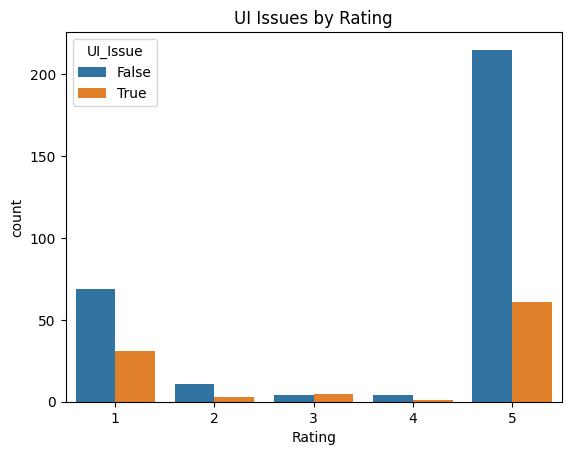

In [26]:
# Common UI complaints
ui_keywords = ['slow', 'lag', 'bug', 'glitch', 'crash', 'freeze', 'complicated', 'hard', 'navigation','unresponsive','delay','latency','stutter',
               'load time','resource intensive','memory leak','instability','error','failure','hang','confusing','difficult','intricate','unintuitive','cumbersome',
               'tedious','user-friendly','accessibility','workflow','steps','process','layout','design','interface','discoverability','pixelated','distorted',
               'alignment','animation','responsiveness','touch','click','scroll','visual','rendering','display','font','color','data loss','sync','save',
               'input','output','search','filter','functionality','feature','compatibility','frustrating','annoying','irritating','problem','issue','bad',
               'poor','broken','useless','disappointing'
]
df['UI_Issue'] = df['Review'].str.contains('|'.join(ui_keywords), case=False)

# % of negative reviews mentioning UI
ui_negative_pct = df[df['Sentiment'] == 'Negative']['UI_Issue'].mean() * 100
print(f"{ui_negative_pct:.1f}% of negative reviews mention UI issues")

# Plot
sns.countplot(data=df, x='Rating', hue='UI_Issue')
plt.title("UI Issues by Rating")
plt.show()

In [27]:
# Filter negative reviews (1-3 stars)
negative_reviews = df[df['Rating'] <= 3].copy()

# Define UI/UX-related keywords
ui_keywords = [
    'ui', 'ux', 'design', 'interface', 'layout', 'navigation', 'confusing', 'complicated', 'cluttered', 'ugly', 'slow',
    'lag', 'bug', 'glitch', 'freeze', 'crash', 'unresponsive','hard to use', 'not intuitive', 'frustrating', 'annoying','hard to navigate', 'slow loading', 
    'confusing layout','crashes frequently', 'ugly design','unresponsive buttons','too many clicks', 'laggy', 'cluttered''slow', 'lag', 'bug', 
    'glitch', 'crash', 'freeze', 'complicated', 'hard', 'navigation','unresponsive','delay','latency','stutter','load time','resource intensive',
    'memory leak','instability','error','failure','hang','confusing','difficult','intricate','unintuitive','cumbersome',
    'tedious','user-friendly','accessibility','workflow','steps','process','layout','design','interface','discoverability','pixelated','distorted',
    'alignment','animation','responsiveness','touch','click','scroll','visual','rendering','display','font','color','data loss','sync','save',
    'input','output','search','filter','functionality','feature','compatibility','frustrating','annoying','irritating','problem','issue','bad',
    'poor','broken','useless','disappointing'
]


# Flag reviews mentioning UI issues
negative_reviews['UI_Complaint'] = negative_reviews['Review'].str.contains(
    '|'.join(ui_keywords), 
    case=False, 
    regex=True
)

# Calculate % of negative reviews mentioning UI
ui_complaint_pct = negative_reviews['UI_Complaint'].mean() * 100
print(f"🔴 **{ui_complaint_pct:.1f}% of negative reviews mention UI/UX issues**")

🔴 **31.7% of negative reviews mention UI/UX issues**


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Only analyze reviews with UI complaints
ui_complaints = negative_reviews[negative_reviews['UI_Complaint']]['Review']

# TF-IDF for bigrams (phrases like "hard to navigate")
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),  # single words + 2-word phrases
    max_features=50
)

tfidf_matrix = tfidf.fit_transform(ui_complaints)
tfidf_scores = dict(zip(tfidf.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Top 10 UI complaints
top_ui_complaints = pd.DataFrame(
    sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:15],
    columns=['Complaint', 'TF-IDF Score']
)

print("🚨 **Top 10 UI/UX Complaints**")
print(top_ui_complaints)

🚨 **Top 10 UI/UX Complaints**
     Complaint  TF-IDF Score
0          app      7.233121
1        order      4.598433
2     products      4.387052
3        stock      2.958477
4       refund      2.734700
5         good      2.436040
6       doesnt      2.300701
7      useless      2.280709
8      address      2.195471
9     customer      2.117432
10         day      2.077503
11      option      1.985048
12        work      1.893918
13  experience      1.809248
14         bad      1.795661


In [29]:
# Get sentiment for UI complaints
ui_complaints_sentiment = negative_reviews[negative_reviews['UI_Complaint']]['Sentiment_Score']

print("📊 **Sentiment Analysis of UI Complaints**")
print(f"Average Sentiment Score: {ui_complaints_sentiment.mean():.2f} (Very Negative)")
print(f"Most Extreme Complaint: {ui_complaints_sentiment.min():.2f}")

📊 **Sentiment Analysis of UI Complaints**
Average Sentiment Score: -0.23 (Very Negative)
Most Extreme Complaint: -0.91


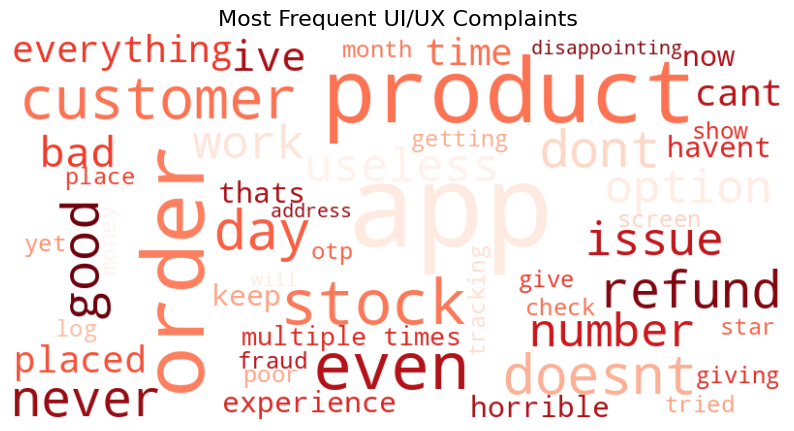

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all UI complaints into one text
all_ui_complaints = ' '.join(ui_complaints)

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    colormap='Reds',  # Red = Negative sentiment
    max_words=50
).generate(all_ui_complaints)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent UI/UX Complaints", fontsize=16)
plt.show()

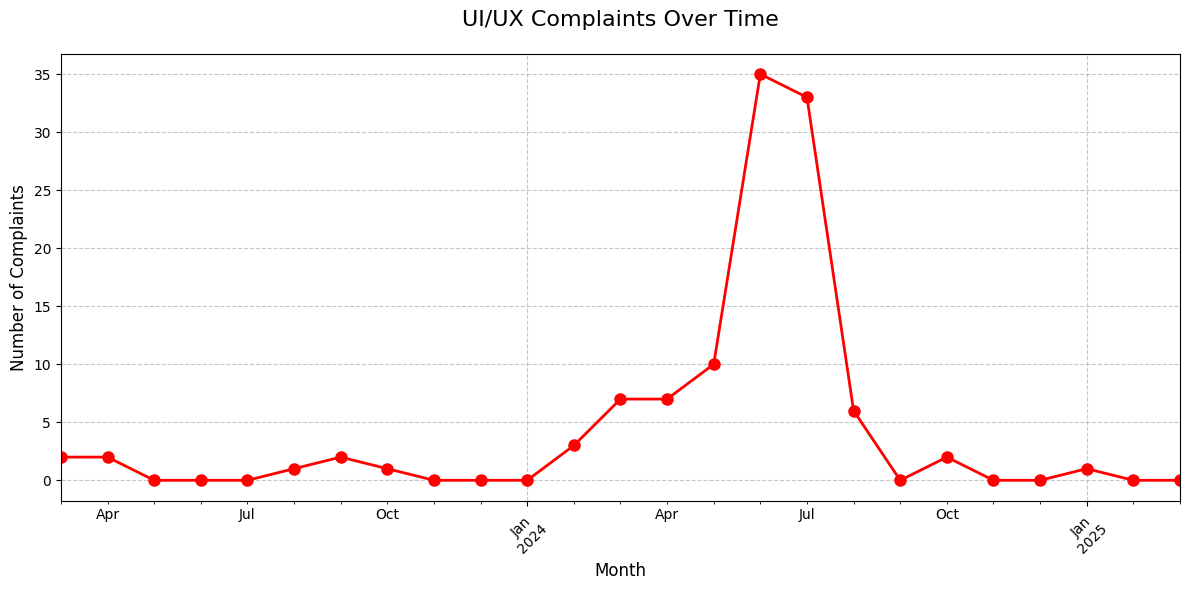


UI Complaint Analysis Summary:
Total UI complaints: 112
Percentage of all reviews: 27.7%
Month with most complaints: 2024-06 (35 complaints)


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Create the UI complaint flag (handles missing values)
df['UI_Complaint'] = df['Review'].apply(
    lambda x: bool(re.search('|'.join(ui_keywords), str(x).lower())) 
    if pd.notnull(x) else False
)

# 2. Now analyze trends only if we have the required columns
required_columns = ['Date', 'UI_Complaint']
if all(col in df.columns for col in required_columns):
    
    # Convert to datetime and extract month
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Month'] = df['Date'].dt.to_period('M')
    
    # Calculate complaint trends
    ui_complaints_trend = (
        df[df['UI_Complaint']]
        .groupby('Month')
        .size()
        .reindex(pd.period_range(
            start=df['Month'].min(),
            end=df['Month'].max(),
            freq='M'
        ), fill_value=0)
    )
    
    # Plot with improved formatting
    plt.figure(figsize=(12, 6))
    ax = ui_complaints_trend.plot(
        marker='o', 
        color='red',
        linewidth=2,
        markersize=8
    )
    
    # Formatting
    plt.title("UI/UX Complaints Over Time", fontsize=16, pad=20)
    plt.ylabel("Number of Complaints", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels if needed
    if len(ui_complaints_trend) > 6:
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nUI Complaint Analysis Summary:")
    print(f"Total UI complaints: {df['UI_Complaint'].sum()}")
    print(f"Percentage of all reviews: {df['UI_Complaint'].mean()*100:.1f}%")
    print(f"Month with most complaints: {ui_complaints_trend.idxmax()} ({ui_complaints_trend.max()} complaints)")
    
else:
    missing = [col for col in required_columns if col not in df.columns]
    print(f"Cannot analyze - missing columns: {missing}")

In [32]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,"[dont, download, app, havent, paid, employees]",False,False,2025-03
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,"[sad, see, kult, downfallits, one, fav, app]",False,False,2025-02
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,"[discount, joke, dont, even, discount, good, p...",False,False,2025-02
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,"[let, browse, without, signing, straight, data...",False,False,2025-01
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,"[app, doesnt, send, otp, login]",False,False,2025-01


In [33]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,"[dont, download, app, havent, paid, employees]",False,False,2025-03
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,"[sad, see, kult, downfallits, one, fav, app]",False,False,2025-02
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,"[discount, joke, dont, even, discount, good, p...",False,False,2025-02
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,"[let, browse, without, signing, straight, data...",False,False,2025-01
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,"[app, doesnt, send, otp, login]",False,False,2025-01


Performance & Bug Detection Analytics

In [34]:
# Define performance-related keywords
performance_keywords = [
    'crash','freeze','lag','slow','bug','glitch','not responding','stuck','hangs',
    'loading','performance','unstable','error','delay','latency','stutter','load time',
    'resource intensive','memory leak','instability','failure','unresponsive','rendering','optimization'
]

# Flag reviews mentioning performance issues
df['Performance_Issue'] = df['Review'].str.contains(
    '|'.join(performance_keywords), 
    case=False, 
    regex=True
)

# Calculate percentage
performance_pct = df['Performance_Issue'].mean() * 100
print(f"🚨 {performance_pct:.1f}% of reviews mention performance issues")

# Breakdown by rating
performance_by_rating = df.groupby('Rating')['Performance_Issue'].mean() * 100
print("\nPerformance Issues by Rating:")
print(performance_by_rating)

🚨 3.0% of reviews mention performance issues

Performance Issues by Rating:
Rating
1     8.000000
2     7.142857
3    22.222222
4     0.000000
5     0.362319
Name: Performance_Issue, dtype: float64


## Feature Requests & Missing Functionalities Analysis

In [35]:
import re
from collections import Counter

# Define feature request indicators
request_phrases = [
    'should have','need','want','please add','where is','why no','missing','would love','wish there was','suggest','recommend',
    'hope to see','require','desire','looking for','could use','it would be great if','it would be helpful if','is there a way to',
    'is it possible to','consider adding','Id like to see',
    'Im trying to find','can you implement','how do I','is it possible to get','is there','Im looking for'
]

# Filter reviews containing feature requests
feature_requests = df[df['Review'].str.contains('|'.join(request_phrases), case=False, na=False)].copy()

print(f"🔍 Found {len(feature_requests)} reviews containing feature requests ({len(feature_requests)/len(df):.1%} of total)")

# Extract requested features using NLP patterns
def extract_feature_requests(text):
    patterns = [
        r'(?:should have|need|want|please add|wish there was) (.+?)[\.\?!]',
        r'(?:why no|where is) (.+?)[\.\?!]',
        r'(?:missing) (.+?)[\.\?!]'
    ]
    features = []
    for pattern in patterns:
        matches = re.findall(pattern, text, flags=re.IGNORECASE)
        features.extend([match.strip() for match in matches])
    return features

feature_requests['Extracted_Features'] = feature_requests['Review'].apply(extract_feature_requests)

🔍 Found 85 reviews containing feature requests (21.0% of total)


In [36]:
# Identify negative reviews mentioning missing features
negative_reviews = df[df['Rating'] <= 3]
negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(
    r'\b(missing|lack|no|without|where is|why no)\b.+?\b(feature|functionality|option)\b', 
    case=False
)

missing_feature_pct = negative_reviews['Missing_Feature'].mean() * 100
print(f"\n🔴 {missing_feature_pct:.1f}% of negative reviews cite missing features")

# Compare to positive reviews
if 'Rating' in df.columns:
    positive_reviews = df[df['Rating'] >= 4]
    pos_missing_pct = positive_reviews['Review'].str.contains(
        r'would love|wish there was|hope to see', 
        case=False
    ).mean() * 100
    
    print(f"🟢 Only {pos_missing_pct:.1f}% of positive reviews mention desired features")
    print(f"⭐ Gap: {missing_feature_pct - pos_missing_pct:.1f} percentage points")


🔴 4.1% of negative reviews cite missing features
🟢 Only 1.1% of positive reviews mention desired features
⭐ Gap: 3.0 percentage points


/var/folders/6d/_h_2x7gj7s17l9hkm1jq2x2w0000gp/T/ipykernel_37739/4150769296.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(
/var/folders/6d/_h_2x7gj7s17l9hkm1jq2x2w0000gp/T/ipykernel_37739/4150769296.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_reviews['Missing_Feature'] = negative_reviews['Review'].str.contains(


Customer Support & Responsiveness Analytics

🚨 13.6% of all reviews mention customer support issues

Support Complaints by Rating:
Rating
1    21.000000
2    14.285714
3    22.222222
4    20.000000
5    10.507246
Name: Support_Complaint, dtype: float64


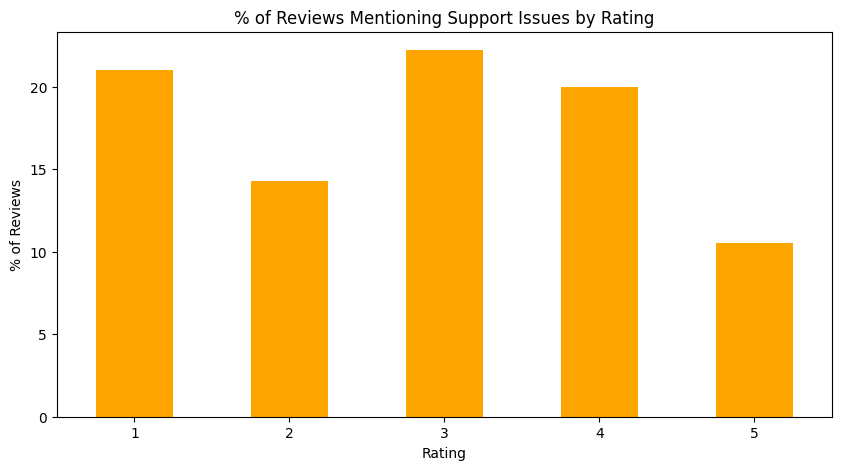

In [37]:
# Define customer support keywords
support_keywords = ['support','customer service','help','contact','response','team','reply','no answer','ignored','no help',
    'terrible service','assistance','feedback','ticket','issue','resolution','agent','representative','email','phone','chat',
    'live chat','forum','documentation','knowledge base','escalate','follow up','wait time','availability','inquiry','problem','complaint',
    'dissatisfied','unhelpful','ineffective','slow response','lack of support','poor service','account support','technical support','billing support'
]

# Flag reviews mentioning support issues
df['Support_Complaint'] = df['Review'].str.contains(
    '|'.join(support_keywords), 
    case=False, 
    na=False
)

# Calculate complaint frequency
support_complaint_pct = df['Support_Complaint'].mean() * 100
support_by_rating = df.groupby('Rating')['Support_Complaint'].mean() * 100

print(f"🚨 {support_complaint_pct:.1f}% of all reviews mention customer support issues")
print("\nSupport Complaints by Rating:")
print(support_by_rating)

# Plot
plt.figure(figsize=(10, 5))
support_by_rating.plot(kind='bar', color='orange')
plt.title("% of Reviews Mentioning Support Issues by Rating")
plt.ylabel("% of Reviews")
plt.xticks(rotation=0)
plt.show()


⏱️ Average response time to negative reviews: 3.9 days
⏱️ Median response time: 2.0 days


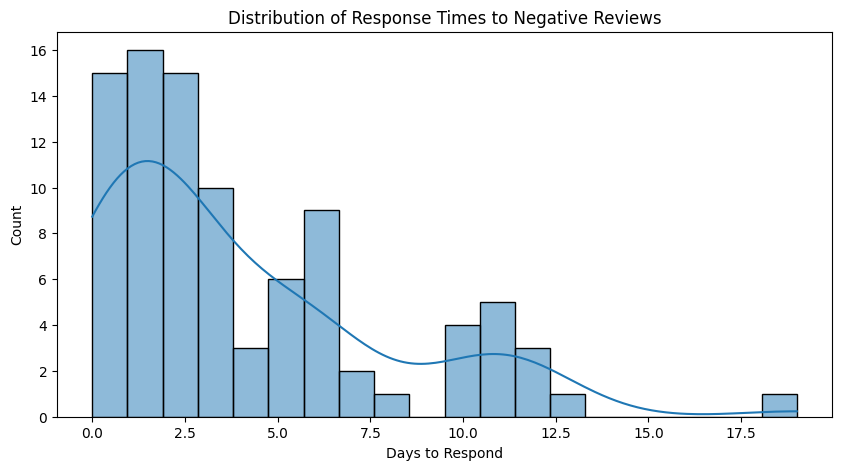

In [38]:
# Calculate response time in days (only for replied reviews)
df['Response_Time_Days'] = (df['Reply Date'] - df['Date']).dt.days

# Analyze response time for negative reviews
negative_with_replies = df[(df['Rating'] <= 3) & (df['Reply'] != "No Reply")]
avg_response_time = negative_with_replies['Response_Time_Days'].mean()
median_response_time = negative_with_replies['Response_Time_Days'].median()

print(f"\n⏱️ Average response time to negative reviews: {avg_response_time:.1f} days")
print(f"⏱️ Median response time: {median_response_time:.1f} days")

# Distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(negative_with_replies['Response_Time_Days'], bins=20, kde=True)
plt.title("Distribution of Response Times to Negative Reviews")
plt.xlabel("Days to Respond")
plt.show()


😊 Average sentiment score for replied reviews: 0.53
😠 Average sentiment score for non-replied reviews: -0.28
📈 Difference: 0.81 points


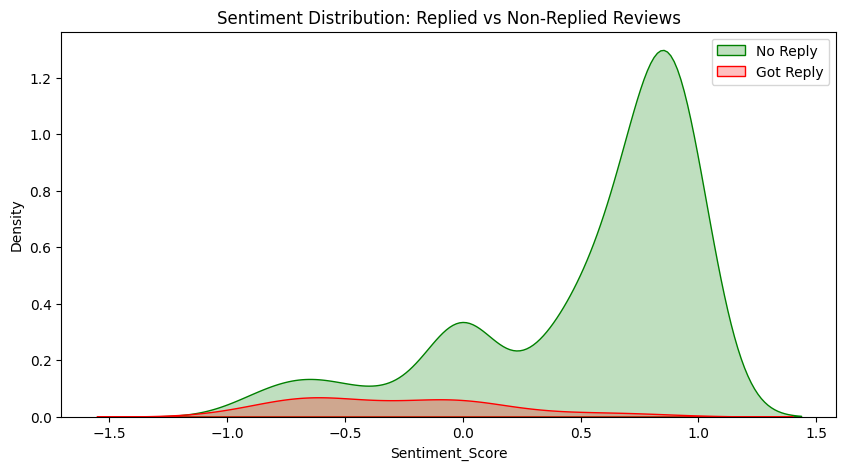

In [39]:
# Compare sentiment between replied vs non-replied reviews
if 'Sentiment_Score' in df.columns:
    replied_sentiment = df[df['Reply'] != "No Reply"]['Sentiment_Score'].mean()
    non_replied_sentiment = df[df['Reply'] == "No Reply"]['Sentiment_Score'].mean()
    
    print(f"\n😊 Average sentiment score for replied reviews: {replied_sentiment:.2f}")
    print(f"😠 Average sentiment score for non-replied reviews: {non_replied_sentiment:.2f}")
    print(f"📈 Difference: {replied_sentiment - non_replied_sentiment:.2f} points")

    # Sentiment distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x='Sentiment_Score', hue=(df['Reply'] != "No Reply"), 
                palette=['red', 'green'], fill=True)
    plt.title("Sentiment Distribution: Replied vs Non-Replied Reviews")
    plt.legend(['No Reply', 'Got Reply'])
    plt.show()

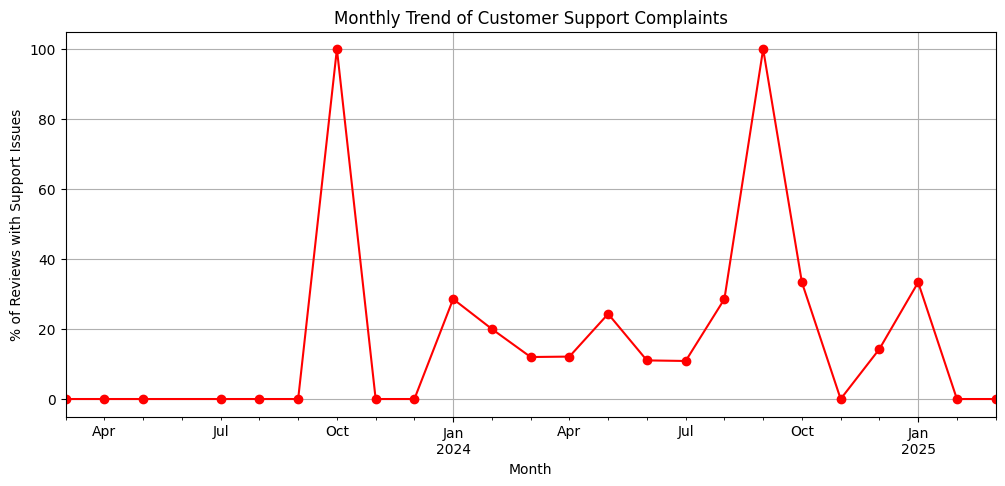

In [40]:
if 'Date' in df.columns:
    # Monthly trend of support complaints
    df['Month'] = df['Date'].dt.to_period('M')
    monthly_support = df.groupby('Month')['Support_Complaint'].mean() * 100
    
    # Plot
    plt.figure(figsize=(12, 5))
    monthly_support.plot(marker='o', color='red')
    plt.title("Monthly Trend of Customer Support Complaints")
    plt.ylabel("% of Reviews with Support Issues")
    plt.grid(True)
    plt.show()

In [41]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month,Performance_Issue,Support_Complaint,Response_Time_Days
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,"[dont, download, app, havent, paid, employees]",False,False,2025-03,False,False,NaN
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,"[sad, see, kult, downfallits, one, fav, app]",False,False,2025-02,False,False,NaN
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,"[discount, joke, dont, even, discount, good, p...",False,False,2025-02,False,False,NaN
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,"[let, browse, without, signing, straight, data...",False,False,2025-01,False,False,NaN
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,"[app, doesnt, send, otp, login]",False,False,2025-01,False,False,NaN


In [42]:
# Priority calculation
support_priority = {
    'Issue': ['Slow response', 'Unhelpful replies', 'No response'],
    'Frequency': [
        (df['Response_Time_Days'] > 7).mean() * 100,
        df[df['Reply'] != "No Reply"]['Review'].str.contains('not helpful|did not solve', case=False).mean() * 100,
        (df['Reply'] == "No Reply").mean() * 100
    ]
}
pd.DataFrame(support_priority).sort_values('Frequency', ascending=False)

,Issue,Frequency
0,Slow response,25.742574
2,No response,8.415842
1,Unhelpful replies,0.000000


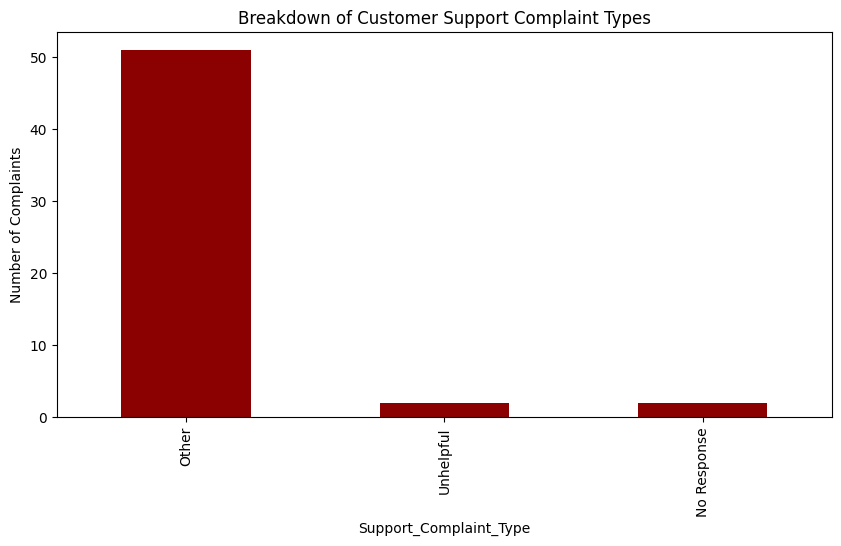

In [43]:
# Classify support complaints into categories
support_categories = {
    'No Response': ['no reply', 'no answer', 'ignored', 'no help', 'no response', 'never responded', 'no feedback'],
    'Slow Response': ['slow response', 'took long', 'days to reply', 'delayed response', 'long wait', 'prolonged delay', 'late reply'],
    'Unhelpful': ['not helpful', 'useless', 'did not solve', 'waste of time', 'ineffective', 'unhelpful', 'did not assist', 'no solution', 'failed to resolve'],
    'Rude Staff': ['rude', 'arrogant', 'unprofessional', 'angry', 'impolite', 'disrespectful', 'hostile', 'offensive', 'dismissive']
}

# Tag each support complaint
def categorize_complaint(text):
    text = str(text).lower()
    for category, keywords in support_categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

df['Support_Complaint_Type'] = df[df['Support_Complaint']]['Review'].apply(categorize_complaint)

# Plot complaint types
plt.figure(figsize=(10, 5))
df['Support_Complaint_Type'].value_counts().plot(kind='bar', color='darkred')
plt.title("Breakdown of Customer Support Complaint Types")
plt.ylabel("Number of Complaints")
plt.show()

In [44]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,Tokens,UI_Issue,UI_Complaint,Month,Performance_Issue,Support_Complaint,Response_Time_Days,Support_Complaint_Type
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,"[dont, download, app, havent, paid, employees]",False,False,2025-03,False,False,NaN,NaN
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,"[sad, see, kult, downfallits, one, fav, app]",False,False,2025-02,False,False,NaN,NaN
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,"[discount, joke, dont, even, discount, good, p...",False,False,2025-02,False,False,NaN,NaN
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,"[let, browse, without, signing, straight, data...",False,False,2025-01,False,False,NaN,NaN
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,"[app, doesnt, send, otp, login]",False,False,2025-01,False,False,NaN,NaN


In [45]:
import numpy as np
# Define response time tiers
bins = [0, 1, 3, 7, 14, np.inf]
labels = ['<1 day', '1-3 days', '4-7 days', '1-2 weeks', '>2 weeks']
df['Response_Tier'] = pd.cut(df['Response_Time_Days'], bins=bins, labels=labels)

# Response time distribution
response_dist = df[df['Reply'] != "No Reply"]['Response_Tier'].value_counts(normalize=True) * 100
print("Response Time Distribution:")
print(response_dist)

# Impact on rating
response_rating = df.groupby('Response_Tier')['Rating'].mean()
print("\nAverage Rating by Response Time:")
print(response_rating)

Response Time Distribution:
Response_Tier
1-3 days     25.748503
4-7 days     22.455090
<1 day       20.658683
1-2 weeks    17.964072
>2 weeks     13.173653
Name: proportion, dtype: float64

Average Rating by Response Time:
Response_Tier
<1 day       4.231884
1-3 days     3.860465
4-7 days     4.000000
1-2 weeks    4.133333
>2 weeks     4.931818
Name: Rating, dtype: float64


/var/folders/6d/_h_2x7gj7s17l9hkm1jq2x2w0000gp/T/ipykernel_37739/861654891.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  response_rating = df.groupby('Response_Tier')['Rating'].mean()


<Axes: title={'center': 'Weekly Support Metrics'}, xlabel='Date'>

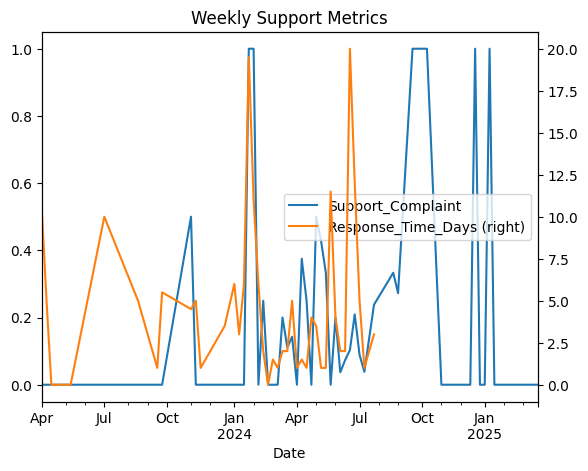

In [46]:
# Weekly support metrics
(df.groupby(df['Date'].dt.to_period('W'))
   .agg({'Support_Complaint': 'mean', 'Response_Time_Days': 'median'})
   .plot(secondary_y='Response_Time_Days', title="Weekly Support Metrics"))

In [47]:
# Key Metrics Summary
support_kpis = {
    'Current Response Time (Days)': df['Response_Time_Days'].median(),
    'Target Response Time': 2,
    'Complaint Rate': df['Support_Complaint'].mean() * 100,
    'Target Complaint Rate': 15,
    'Reply Coverage': (df['Reply'] != "No Reply").mean() * 100,
    'Target Coverage': 90,
    'Positive Reply Impact': replied_sentiment - non_replied_sentiment
}

kpi_df = pd.DataFrame.from_dict(support_kpis, orient='index', columns=['Value'])
kpi_df['Status'] = np.where(
    (kpi_df.index.str.contains('Time|Rate')) & (kpi_df['Value'] > kpi_df['Value'].shift(-1)),
    '❌ Needs Improvement',
    '✅ On Track'
)

print("\n📊 Customer Support KPI Dashboard:")
print(kpi_df)

# Automated Alert System
if support_kpis['Current Response Time (Days)'] > 3:
    print("\n🔴 ALERT: Response times exceeding 3-day target!")
if support_kpis['Complaint Rate'] > 25:
    print("🔴 ALERT: Support complaint rate above 25%!")


📊 Customer Support KPI Dashboard:
                                  Value               Status
Current Response Time (Days)   3.000000  ❌ Needs Improvement
Target Response Time           2.000000           ✅ On Track
Complaint Rate                13.613861           ✅ On Track
Target Complaint Rate         15.000000           ✅ On Track
Reply Coverage                91.584158           ✅ On Track
Target Coverage               90.000000           ✅ On Track
Positive Reply Impact          0.809326           ✅ On Track


Monetization & Subscription Feedback Analysis

💰 10.4% of reviews mention pricing issues

Pricing Complaints by Rating:
Rating
1    23.000000
2     0.000000
3     0.000000
4    20.000000
5     6.521739
Name: Pricing_Complaint, dtype: float64


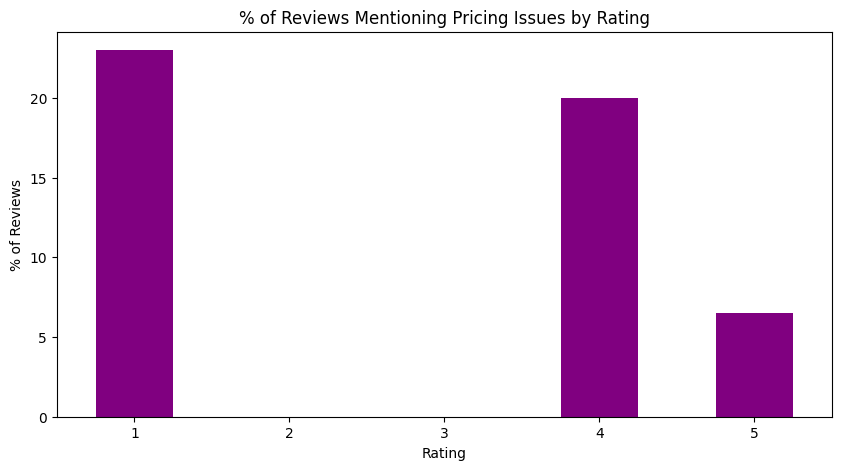

In [48]:
# Define pricing-related keywords
pricing_keywords = ['expensive','overpriced','pricey','too much','not worth','high price','cost too much','unfair','cheaper','lower price',
    'reduce price','price hike','cost','value','affordable','budget','premium','subscription','billing','payment','discount',
    'sale','refund','charge','fees','rates','economical','reasonable','inaccessible','exorbitant','rip off','free trial',
    'hidden fees','monthly cost','yearly cost','value for money'
]
# Flag pricing complaints
df['Pricing_Complaint'] = df['Review'].str.contains(
    '|'.join(pricing_keywords), 
    case=False, 
    na=False
)

# Calculate pricing complaint metrics
pricing_complaint_pct = df['Pricing_Complaint'].mean() * 100
pricing_by_rating = df.groupby('Rating')['Pricing_Complaint'].mean() * 100

print(f"💰 {pricing_complaint_pct:.1f}% of reviews mention pricing issues")
print("\nPricing Complaints by Rating:")
print(pricing_by_rating)

# Plot
plt.figure(figsize=(10, 5))
pricing_by_rating.plot(kind='bar', color='purple')
plt.title("% of Reviews Mentioning Pricing Issues by Rating")
plt.ylabel("% of Reviews")
plt.xticks(rotation=0)
plt.show()

In [49]:
# # Compare pricing complaints before/after price changes
# if 'Date' in df.columns:
#     # Example: Price change occurred on 2024-01-15
#     price_change_date = pd.to_datetime('2024-01-15')
#     df['Post_Price_Change'] = df['Date'] > price_change_date
    
#     pricing_complaint_change = df.groupby('Post_Price_Change')['Pricing_Complaint'].mean() * 100
#     print("\nPricing Complaints Before vs After Price Change:")
#     print(pricing_complaint_change)


🔄 5.4% of reviews mention subscription/IAP issues

Subscription Complaints by Rating:
Rating
1    20.000000
2     7.142857
3     0.000000
4     0.000000
5     0.362319
Name: Subscription_Complaint, dtype: float64


<Figure size 800x500 with 0 Axes>

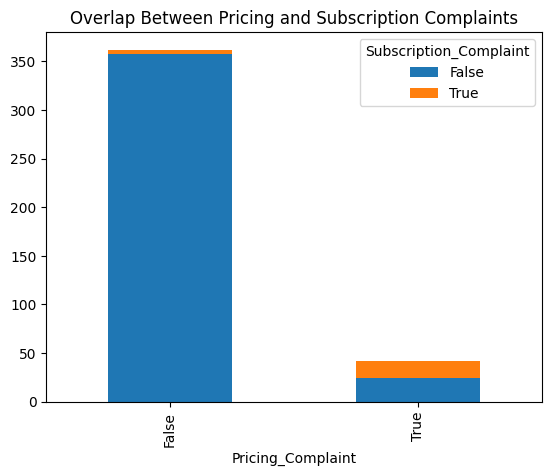

In [50]:
# Define subscription/IAP keywords
subscription_keywords = ['subscription','renewal','auto-renew','cancel','refund','billing','charge','payment','iap','in-app purchase',
    'trial','scam','unsubscribe','manage subscription','subscription fees','subscription cost','subscription service','membership',
    'recurring payment','subscription plan','subscription model','subscription options','subscription terms','subscription issues',
    'subscription problems','subscription error','subscription expired','subscription active','subscription paused','subscription status',
    'subscription details','subscription access','subscription account','subscription support','subscription help','subscription cancellation',
    'subscription confirmation','subscription history','subscription information'
]

# Flag subscription complaints
df['Subscription_Complaint'] = df['Review'].str.contains(
    '|'.join(subscription_keywords), 
    case=False, 
    na=False
)

# Calculate metrics
subscription_complaint_pct = df['Subscription_Complaint'].mean() * 100
subscription_by_rating = df.groupby('Rating')['Subscription_Complaint'].mean() * 100

print(f"\n🔄 {subscription_complaint_pct:.1f}% of reviews mention subscription/IAP issues")
print("\nSubscription Complaints by Rating:")
print(subscription_by_rating)

# Plot overlap between pricing and subscription complaints
plt.figure(figsize=(8, 5))
pd.crosstab(df['Pricing_Complaint'], df['Subscription_Complaint']).plot(
    kind='bar', stacked=True, 
    title="Overlap Between Pricing and Subscription Complaints"
)
plt.show()

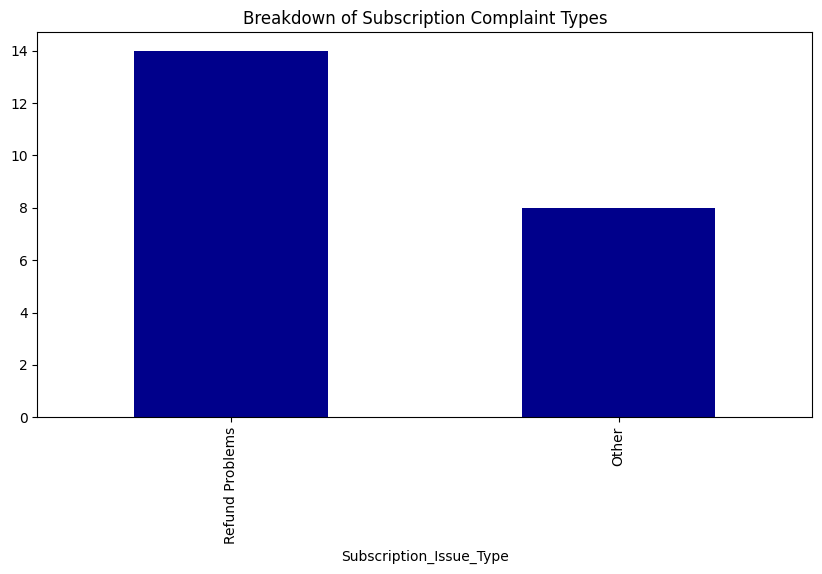

In [51]:
# Extract specific subscription issues
subscription_issues = {
    'Auto-Renewal': ['auto-renew', 'unsubscribe', 'hard to cancel', 'difficult to cancel', 'automatic renewal', 'cancellation problems', 'cannot unsubscribe'],
    'Unexpected Charges': ['unexpected charge', 'hidden fee', 'surprise charge', 'unauthorized charge', 'extra fees', 'unknown charge', 'incorrect billing'],
    'Refund Problems': ['refund', 'money back', 'not refund', 'no refund', 'refund denied', 'refund issues', 'refund process', 'refund policy'],
    'Value Issues': ['not worth', 'waste of money', 'better free', 'overpriced subscription', 'poor value', 'not worth the cost', 'expensive for what it offers']
}

# Categorize subscription complaints
def categorize_sub_issue(text):
    text = str(text).lower()
    for category, keywords in subscription_issues.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

df['Subscription_Issue_Type'] = df[df['Subscription_Complaint']]['Review'].apply(categorize_sub_issue)

# Plot issue distribution
plt.figure(figsize=(10, 5))
df['Subscription_Issue_Type'].value_counts().plot(kind='bar', color='darkblue')
plt.title("Breakdown of Subscription Complaint Types")
plt.show()

In [52]:
df.columns

Index(['Username', 'Rating', 'Date', 'Review', 'Reply', 'Reply Date',
       'Usefulness', 'Reply_Time_Days', 'Sentiment_Score', 'Sentiment',
       'Tokens', 'UI_Issue', 'UI_Complaint', 'Month', 'Performance_Issue',
       'Support_Complaint', 'Response_Time_Days', 'Support_Complaint_Type',
       'Response_Tier', 'Pricing_Complaint', 'Subscription_Complaint',
       'Subscription_Issue_Type'],
      dtype='object')

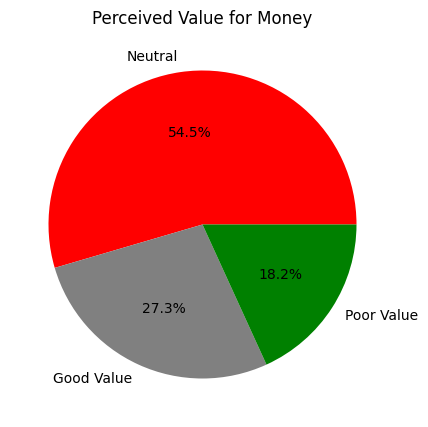

In [53]:
# Isolate reviews discussing pricing
pricing_reviews = df[df['Pricing_Complaint'] | df['Subscription_Complaint']].copy()

# Calculate value sentiment
pricing_reviews['Value_Sentiment'] = pricing_reviews['Review'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

# Categorize value perception
bins = [-1, -0.3, 0.3, 1]
labels = ['Poor Value', 'Neutral', 'Good Value']
pricing_reviews['Value_Perception'] = pd.cut(
    pricing_reviews['Value_Sentiment'], 
    bins=bins, 
    labels=labels
)

# Plot distribution
plt.figure(figsize=(8, 5))
pricing_reviews['Value_Perception'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%',
    colors=['red', 'gray', 'green']
)
plt.title("Perceived Value for Money")
plt.ylabel("")
plt.show()

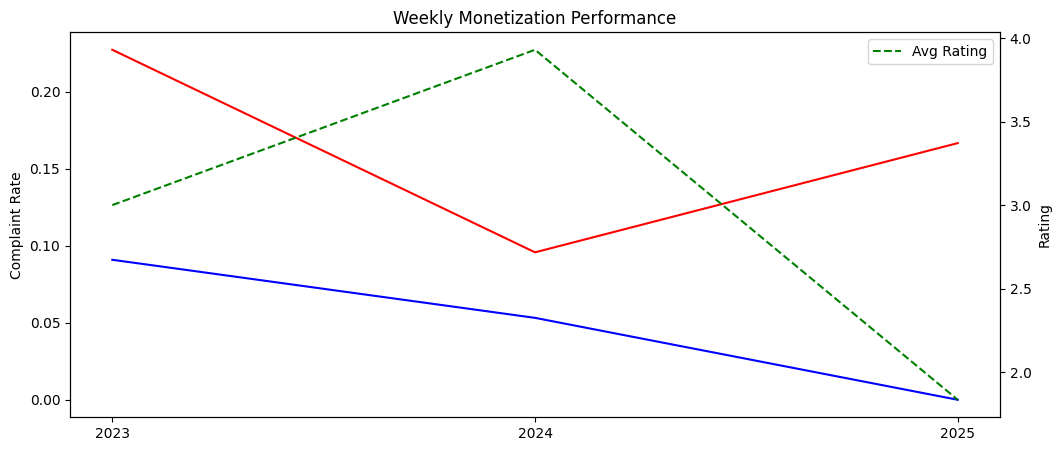

In [54]:
# Key metrics to track weekly
monetization_kpis = df.groupby(df['Date'].dt.to_period('Y')).agg({
    'Pricing_Complaint': 'mean',
    'Subscription_Complaint': 'mean',
    'Rating': 'mean'
})

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monetization_kpis.index.astype(str), monetization_kpis['Pricing_Complaint'], 'r-', label='Pricing Complaints')
ax1.plot(monetization_kpis.index.astype(str), monetization_kpis['Subscription_Complaint'], 'b-', label='Subscription Complaints')
ax2 = ax1.twinx()
ax2.plot(monetization_kpis.index.astype(str), monetization_kpis['Rating'], 'g--', label='Avg Rating')
ax1.set_ylabel('Complaint Rate')
ax2.set_ylabel('Rating')
plt.title("Weekly Monetization Performance")
plt.legend()
plt.show()

Sentiment Analysis & User Retention Deep Dive

In [55]:
# Detect loyal users (those with multiple reviews)
review_counts = df['Username'].value_counts()
df['Review_Count'] = df['Username'].map(review_counts)
df['User_Type'] = np.where(df['Review_Count'] > 1, 'Loyal', 'First-Time')

# Calculate proportions
user_type_pct = df['User_Type'].value_counts(normalize=True) * 100
print(f"👥 User Composition:\n{user_type_pct}")

# Compare sentiment
loyalty_sentiment = df.groupby('User_Type')['Sentiment_Score'].mean()
print(f"\n😊 Average Sentiment:\n{loyalty_sentiment}")

👥 User Composition:
User_Type
First-Time    99.50495
Loyal          0.49505
Name: proportion, dtype: float64

😊 Average Sentiment:
User_Type
First-Time    0.463327
Loyal         0.927300
Name: Sentiment_Score, dtype: float64



📈 Loyal Users' Rating Changes:
Rating_Change
0.0    1
Name: count, dtype: int64


/var/folders/6d/_h_2x7gj7s17l9hkm1jq2x2w0000gp/T/ipykernel_37739/1610781129.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


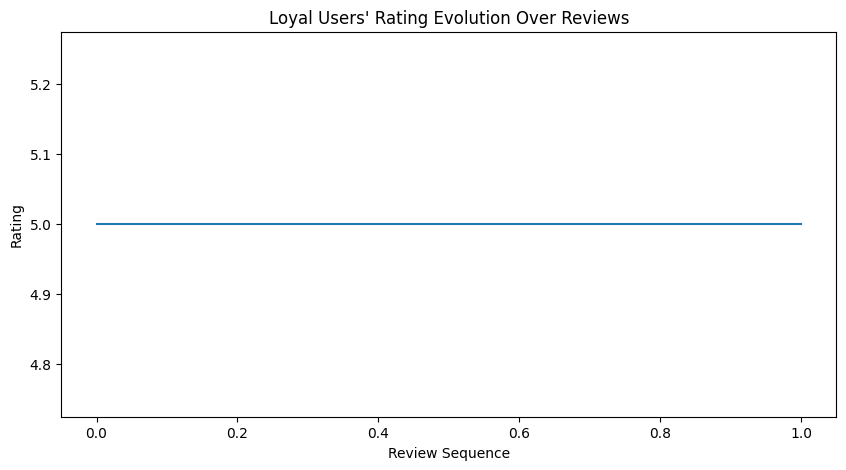

In [56]:
# Track loyal users' rating changes over time
if 'Date' in df.columns and 'User_Type' in df.columns:
    loyal_users = df[df['User_Type'] == 'Loyal'].sort_values(['Username', 'Date'])
    loyal_users['Rating_Change'] = loyal_users.groupby('Username')['Rating'].diff()
    
    print("\n📈 Loyal Users' Rating Changes:")
    print(loyal_users['Rating_Change'].value_counts())
    
    # Plot rating evolution
    plt.figure(figsize=(10, 5))
    sns.lineplot(
        data=loyal_users,
        x=loyal_users.groupby('Username').cumcount(),
        y='Rating',
        ci=None,
        estimator='median'
    )
    plt.title("Loyal Users' Rating Evolution Over Reviews")
    plt.xlabel("Review Sequence")
    plt.ylabel("Rating")
    plt.show()

 Actionable Insights Generator

In [57]:
df.head()

,Username,Rating,Date,Review,Reply,Reply Date,Usefulness,Reply_Time_Days,Sentiment_Score,Sentiment,...,Performance_Issue,Support_Complaint,Response_Time_Days,Support_Complaint_Type,Response_Tier,Pricing_Complaint,Subscription_Complaint,Subscription_Issue_Type,Review_Count,User_Type
0,Rohit Ghansham,1,2025-03-20,dont download this app they havent paid their ...,No Reply,NaT,0,<NA>,0.0000,Neutral,...,False,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
1,Dharshini Priya,5,2025-02-28,it sad to see kult is downfallits one of fav app,No Reply,NaT,1,<NA>,-0.0258,Neutral,...,False,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
2,Riya Paul,1,2025-02-04,75 discount is joke they dont even have 5 disc...,No Reply,NaT,0,<NA>,0.4404,Positive,...,False,False,NaN,NaN,NaN,True,False,NaN,1,First-Time
3,SpaceTimeBeing,1,2025-01-14,let me browse without signing up straight data...,No Reply,NaT,0,<NA>,-0.6080,Negative,...,False,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
4,Clara Spark,2,2025-01-13,this app doesnt send otp to login,No Reply,NaT,0,<NA>,0.0000,Neutral,...,False,False,NaN,NaN,NaN,False,False,NaN,1,First-Time
